In [1]:
import experiments.nns.simplenet.simplenet
from experiments.nns.simplenet.simplenet import SimpleNet
import torch.optim as optim
import torch.nn as nn


model = SimpleNet(num_classes=10, in_chans= 1, scale=1, network_idx=1, mode=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [2]:
import torch
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms



notebook_directory = os.path.dirname(os.path.abspath("deep_ensemble_mnist.ipynb"))
# Navigate to the parent folder (assuming "usr" and "home" are at the same level)
parent_directory = os.path.abspath(os.path.join(notebook_directory, "..","..","..","..","..","..",".."))

# Construct the path to the ImageNet directory
mnist_directory = os.path.abspath(os.path.join(parent_directory, "/usr/data1/vision/data/"))

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST training dataset
train_dataset = datasets.MNIST(root=mnist_directory, train=True, download=False, transform=transform)

# Load the MNIST test dataset
test_dataset = datasets.MNIST(root=mnist_directory, train=False, download=False, transform=transform)

# # Select 1/10 samples of each class for both train and test datasets
# train_subset_indices = []
# test_subset_indices = []

# for c in range(10):
#     class_indices = [i for i in range(len(train_dataset)) if train_dataset[i][1] == c]
#     train_subset_indices.extend(class_indices[:len(class_indices)//10])
    
#     class_indices = [i for i in range(len(test_dataset)) if test_dataset[i][1] == c]
#     test_subset_indices.extend(class_indices[:len(class_indices)//10])

# # Create the subset with 1/10th of the original size for each class
# train_subset = torch.utils.data.Subset(train_dataset, train_subset_indices)

# # Save the subset indices inside mnist_directory
subset_save_path = os.path.join(mnist_directory, "subset_indices.pth")
test_subset_save_path = os.path.join(mnist_directory, "test_subset_indices.pth")
# torch.save(train_subset_indices, subset_save_path)
# torch.save(test_subset_indices, test_subset_save_path)


# Load the subset indices from mnist_directory
loaded_subset_indices = torch.load(subset_save_path)
loaded_test_subset_indices = torch.load(test_subset_save_path)

# Create the subset using the loaded indices
loaded_train_subset = torch.utils.data.Subset(train_dataset, loaded_subset_indices)
loaded_test_subset = torch.utils.data.Subset(test_dataset, loaded_test_subset_indices)

In [3]:
# Create data loaders
batch_size = 128
train_loader = DataLoader(loaded_train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
import torch
from torch.utils.data import DataLoader
import push.bayes.ensemble

epochs = 2
two_particle_ensemble = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.CrossEntropyLoss(),
        epochs,
        SimpleNet, 10, 1, 1, 1, 2,
        num_devices=2,
        num_ensembles=2,
    )

100%|██████████| 2/2 [00:06<00:00,  3.43s/it]


In [5]:
# two_model_outputs = two_particle_ensemble.posterior_pred(test_loader,f_reg=False)
two_model_outputs = two_particle_ensemble.posterior_pred(test_loader,f_reg=False, mode=["mode","logits","mean_prob"])
# two_model_logits = two_particle_ensemble.posterior_pred(test_loader,f_reg=False, mode=["logits"])
# two_model_probabilities = two_particle_ensemble.posterior_pred(test_loader,f_reg=False, mode=["mean_prob"])

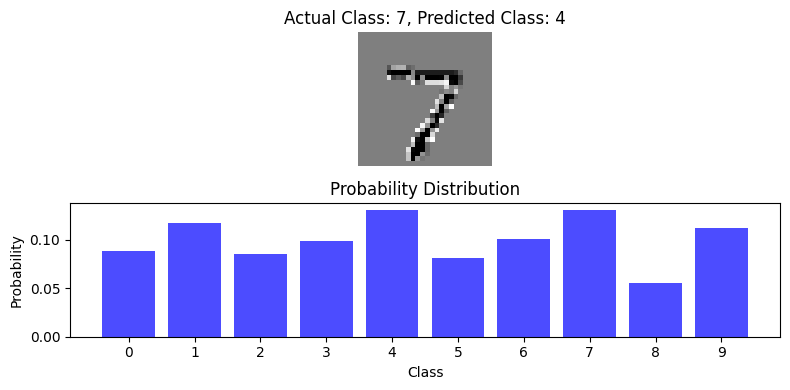

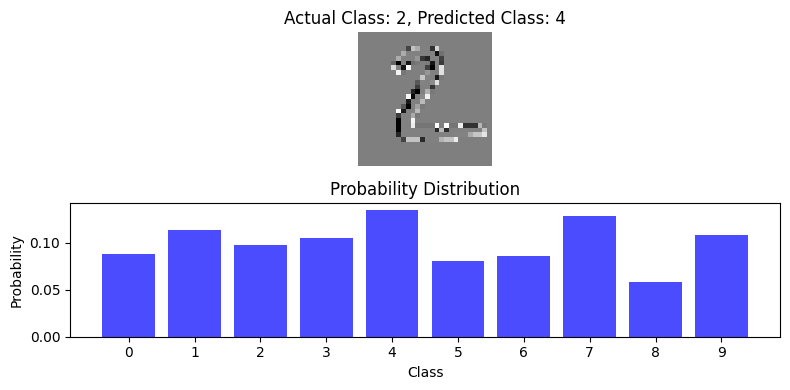

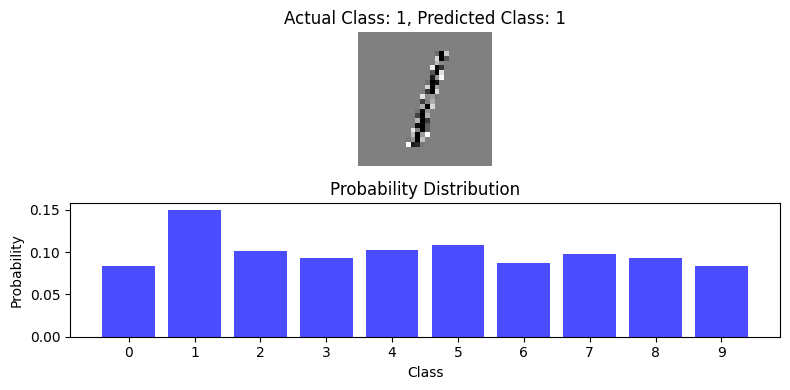

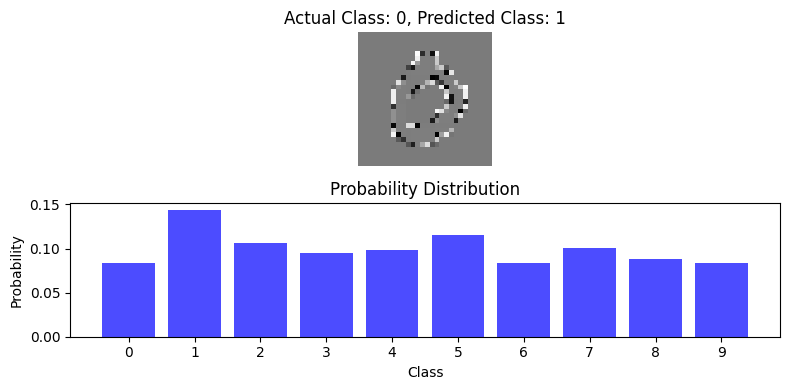

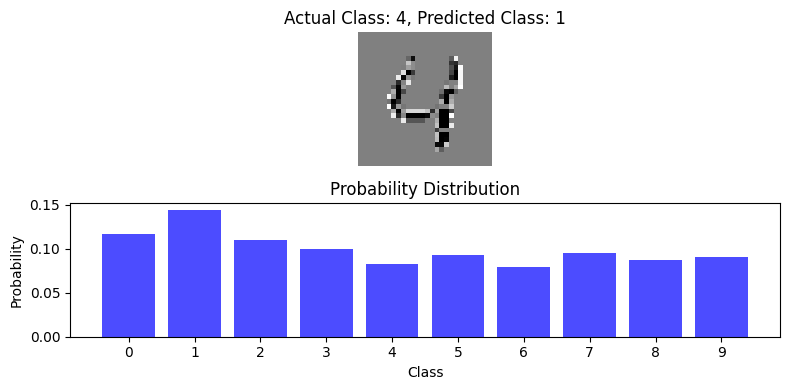

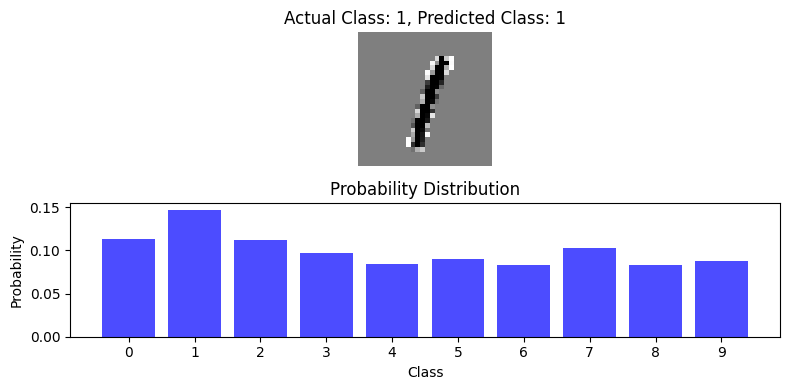

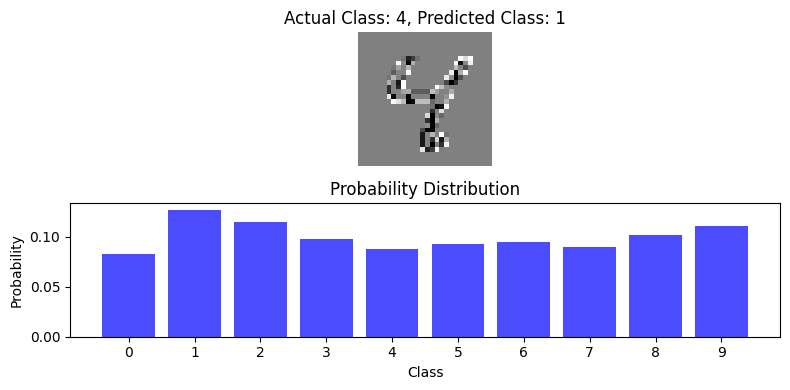

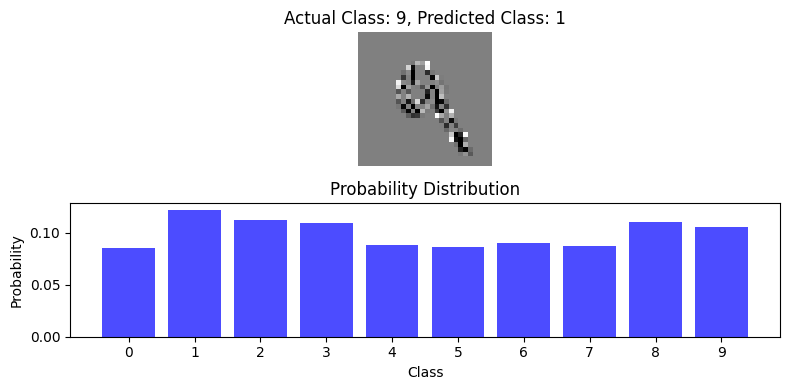

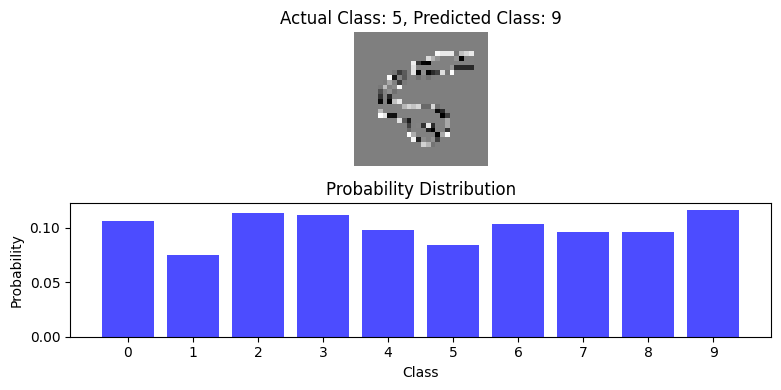

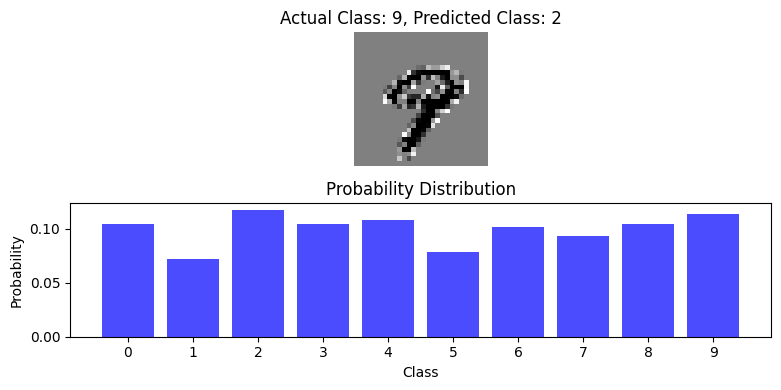

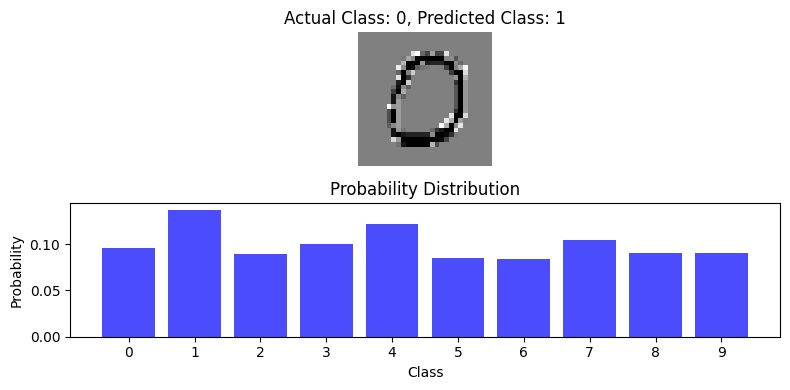

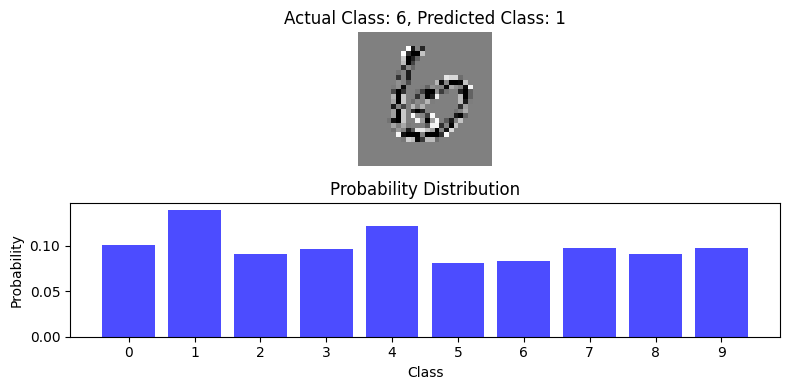

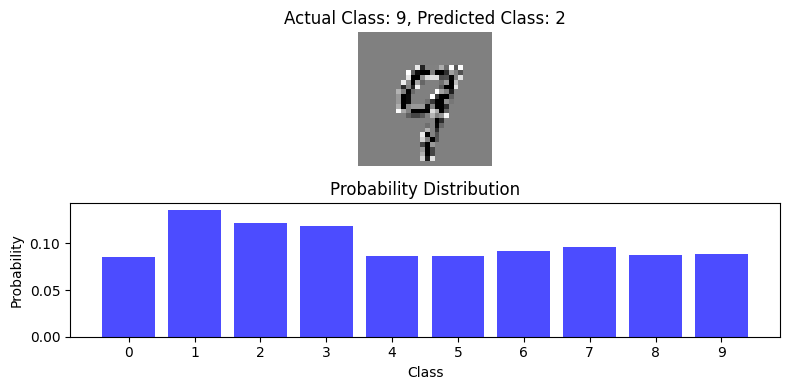

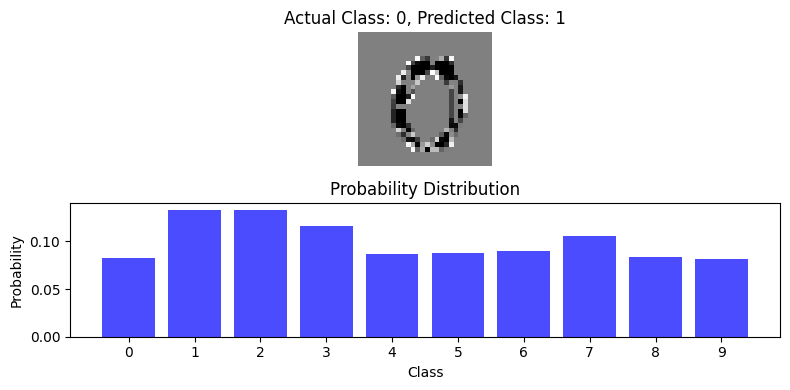

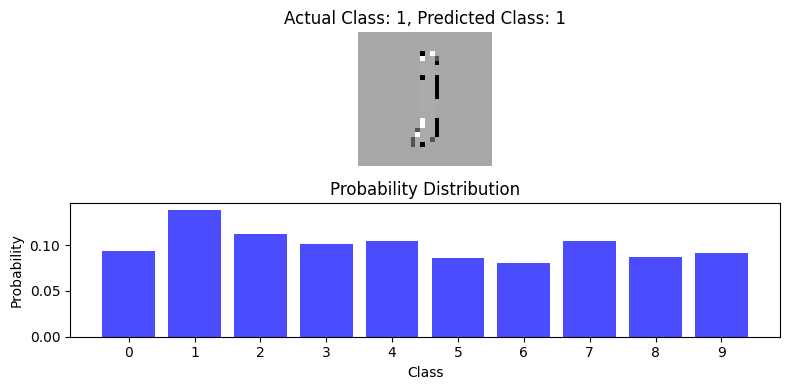

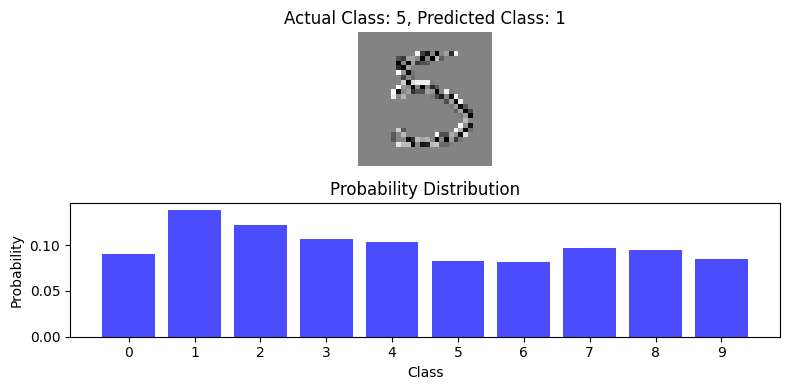

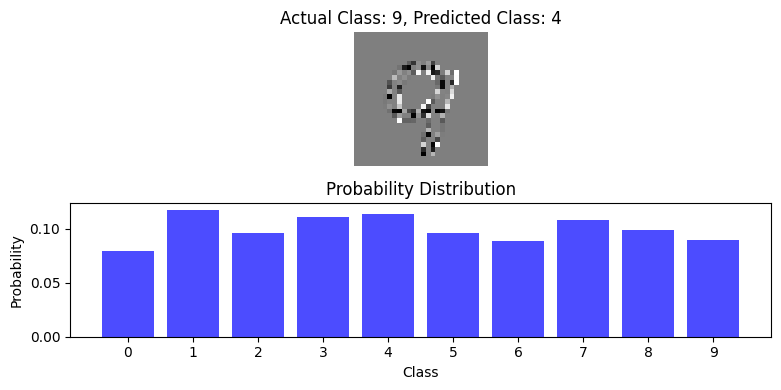

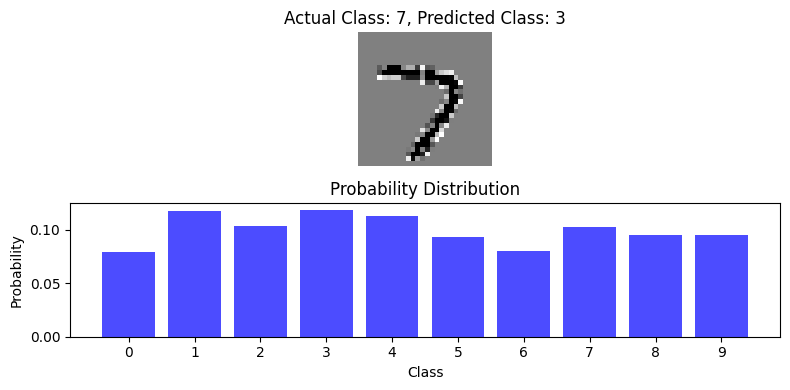

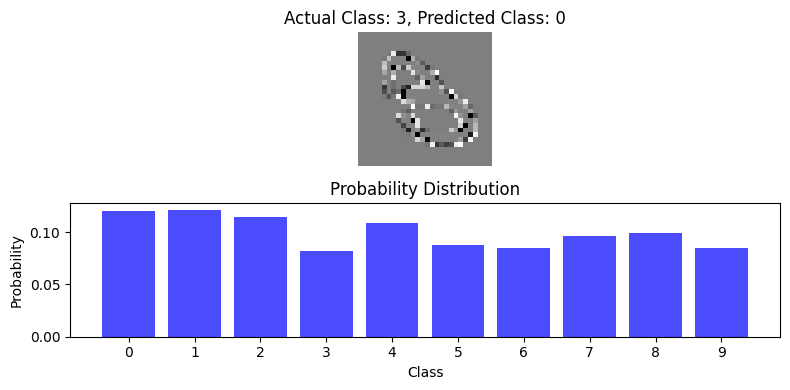

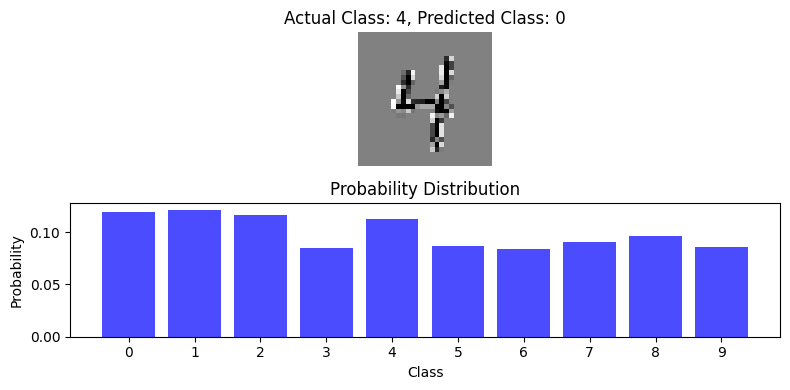

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# Assuming two_model_outputs is your model's output tensor containing predicted classes
# and two_model_probabilities is the tensor containing probabilities
predicted_classes = two_model_outputs["mode"]
probabilities = two_model_outputs["mean_prob"]

# Convert input_images to float tensor before normalization
input_images_float = test_dataset.data.float()

# Add an extra channel dimension (assuming grayscale images)
input_images_float = input_images_float.unsqueeze(1)

# Unnormalize and convert input_images to numpy array
unnormalize = transforms.Compose([transforms.Normalize(mean=-0.5/0.5, std=1/0.5),
                                 transforms.ToPILImage()])

input_images_np = np.array([np.array(unnormalize(img)) for img in input_images_float])

# Get actual labels from the dataset
actual_labels = test_dataset.targets

# Display a few images along with their predicted classes and probability distribution
num_images_to_display = 20

for i in range(num_images_to_display):
    plt.figure(figsize=(8, 4))

    # Plot the image
    plt.subplot(2, 1, 1)
    plt.imshow(input_images_np[i], cmap='gray')
    plt.title(f'Actual Class: {actual_labels[i]}, Predicted Class: {predicted_classes[i]}')
    plt.axis('off')

    # Plot the probability distribution with x-axis values going from 0 to 9
    plt.subplot(2, 1, 2)
    plt.bar(np.arange(0, 10), probabilities[i].numpy(), color='blue', alpha=0.7)
    plt.title("Probability Distribution")
    plt.xlabel("Class")
    plt.ylabel("Probability")

    # Set the x-axis ticks explicitly
    plt.xticks(np.arange(0, 10))

    plt.tight_layout()

plt.show()
